In [1]:
import os
import shutil
import pandas as pd
from PIL import Image
import numpy as np
#import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

img_rows = 150
img_cols = 224
color_type = 3
batch_size=48
epochs=300
subject='Plant-pathology-2020'
main_path=os.path.join("E:\\kaggle_imgs",subject)
img_path=os.path.join(main_path,"images")
data_path=os.path.join(main_path,"Data")
saved_path=os.path.join(main_path,"saved_models")
paths=[main_path, img_path,saved_path,data_path]
for fp in paths:
    print(fp)
    if not os.path.exists(fp):        
        os.mkdir(fp)
file_path=os.path.join(saved_path,subject+"200607_")
file_best=os.path.join(saved_path,subject+"200607_")

train_img_pkl=os.path.join(data_path,"train_imgs.npy")
test_img_pkl=os.path.join(data_path,"test_imgs.npy")
train_info_pkl=os.path.join(data_path,"df_train_pickle.csv")

num_classes=4

E:\kaggle_imgs\Plant-pathology-2020
E:\kaggle_imgs\Plant-pathology-2020\images
E:\kaggle_imgs\Plant-pathology-2020\saved_models
E:\kaggle_imgs\Plant-pathology-2020\Data


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
import visdom
vis=visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

## define value tracker

In [4]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

## Load train data

In [5]:
def read_train_info():
    fp=train_info_pkl
    if False and os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
        
    else:
        df_train=pd.read_csv(data_path+"/train.csv")
        df_train["CAT"]=df_train[['healthy', 'multiple_diseases', 'rust','scab']].values.argmax(axis=1)
        df_train["id"]=df_train["image_id"].apply(lambda x : int(x.split("_")[1]))        
        X=df_train['id'].values
        y=df_train['CAT'].values
        skf=StratifiedKFold(n_splits=5,random_state=22)        
        df_train["fold"]=-1
        sum=0
        for i, (trn_idx,vld_idx) in enumerate(skf.split(X,y)):
            df_train.loc[vld_idx,"fold"]=i
        df_train.to_csv(train_info_pkl,index=False)
        
    return df_train

df_train=read_train_info()


C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## Augmentation

In [6]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
    transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

transform_valid = transforms.Compose([
    transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, Cutout, HorizontalFlip, Normalize
)
from albumentations.pytorch import ToTensor, ToTensorV2
transform_train= Compose([
    Rotate(20),
    ToTensor()
])
transform_valid=Compose([
    ToTensor()
])

## Dataset

In [7]:
from torch.utils.data import Dataset
class PlantDataset(Dataset):
    def __init__(self, df, tr=None):
        self.df = df
        self.tr=tr
        
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        name=self.df.iloc[idx].image_id
        image_src=img_path+"/"+name+".jpg"
        image = Image.open(image_src)
        labels = self.df.iloc[idx].CAT

        if self.tr is not None:
            image=self.tr(image)
        
        return image, labels

## transforms and normalization

In [8]:
sel=1
trn_fold=[i for i in range(5) if i not in [sel]]
val_fold=[i for i in range(5) if i in [sel]]
trn_idx=df_train[df_train.fold.isin(trn_fold)].index
val_idx=df_train[df_train.fold.isin(val_fold)].index
print(trn_idx.shape,val_idx.shape)

(1457,) (364,)


In [9]:
trainset = PlantDataset(df=df_train.loc[trn_idx],
                       tr=transform_train)
validset =PlantDataset(df=df_train.loc[val_idx],
                      tr=transform_valid)

train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=0)

In [10]:
for img,lab in train_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


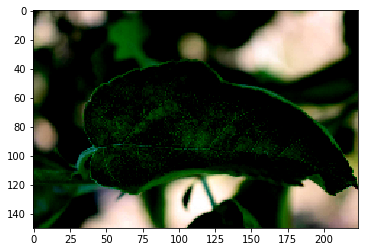

In [11]:
plt.imshow(img[0].permute(1,2,0))

## Model

In [12]:
# import torchvision.models.resnet as resnet

In [13]:
# conv1x1=resnet.conv1x1
# Bottleneck = resnet.Bottleneck
# BasicBlock= resnet.BasicBlock

In [14]:
# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
#         super(ResNet, self).__init__()
#         self.inplanes = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
#         self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
#         self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(128 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         #[-1,3,32,32]
#         x = self.conv1(x)
#         #x.shape =[1, 16, 32,32]
#         x = self.bn1(x)
#         x = self.relu(x)
#         #x = self.maxpool(x)

#         x = self.layer1(x)
#         #x.shape =[1, 128, 32,32]
#         x = self.layer2(x)
#         #x.shape =[1, 256, 32,32]
#         x = self.layer3(x)
#         #x.shape =[1, 512, 16,16]
#         x = self.layer4(x)
#         #x.shape =[1, 1024, 8,8]
        
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x

In [15]:
import torchvision.models  as models
import torch.nn as nn

In [16]:
device='cuda' if torch.cuda.is_available() else 'cpu'
resnet34 = models.resnet34(pretrained=True)
num_ftrs=resnet34.fc.in_features
resnet34.fc=nn.Linear(num_ftrs,num_classes)

In [17]:
resnet34=resnet34.to(device)

In [18]:
a=torch.Tensor(1,3,img_rows,img_cols).to(device)
out = resnet34(a)
print(out)

tensor([[ 0.4573,  0.1852,  1.2456, -0.3204]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [19]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.SGD(resnet34.parameters(),lr=1e-2,momentum=0.9,weight_decay=5e-4)
lr_sched=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

## make plot

In [20]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),
                    opts=dict(title='loss_tracker', 
                              legend=['loss'], 
                              showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),
                   opts=dict(title='Accuracy', 
                             legend=['Acc'],
                             showlegend=True))

## define acc check func

In [21]:
best_acc=0
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    global best_acc
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save and best_acc<acc:
        best_acc=acc
        torch.save(net.state_dict(), file_path+"_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

## train

In [22]:

print(len(train_loader))
epochs = 10

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    lr_sched.step()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(train_loader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(resnet34, valid_loader, epoch, save=1)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

31


C:\Users\ipofri-desktop\anaconda3\envs\tch\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,    30] loss: 0.618
Accuracy of the network on the 10000 test images: 85 %
[2,    30] loss: 0.236
Accuracy of the network on the 10000 test images: 86 %
[3,    30] loss: 0.071
Accuracy of the network on the 10000 test images: 88 %
[4,    30] loss: 0.032
Accuracy of the network on the 10000 test images: 85 %
[5,    30] loss: 0.026
Accuracy of the network on the 10000 test images: 88 %
[6,    30] loss: 0.021
Accuracy of the network on the 10000 test images: 86 %
[7,    30] loss: 0.026
Accuracy of the network on the 10000 test images: 89 %
[8,    30] loss: 0.017
Accuracy of the network on the 10000 test images: 90 %
[9,    30] loss: 0.009
Accuracy of the network on the 10000 test images: 91 %
[10,    30] loss: 0.009
Accuracy of the network on the 10000 test images: 90 %
Finished Training


In [23]:
print(len(train_loader))

31


In [24]:
torch.cuda.current_stream()

<torch.cuda.Stream device=cuda:0 cuda_stream=0x0>

In [25]:
torch.cuda.device_count()

1

In [26]:
torch.cuda.empty_cache()